## Terceira tarefa - MMD - Bruno Cuconato e Laura Sant'Anna

Importing modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pylab as pl
import pandas as pd
import networkx as nx
import codecs
from collections import Counter, OrderedDict
import os
import random as rd
import csv
#from lxml import html
#import requests
from SPARQLWrapper import SPARQLWrapper, JSON
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Specifying the path to the files:

In [2]:
datapath = ""
outputs = ""
#dataset1 = "/tmp/outliers/influences.csv"
dataset1 = "influences.csv"

#### Loading the dataset

In [3]:
csvfile = open(os.path.join(datapath,dataset1), encoding = 'utf-8').readlines()

In [4]:
csvfile[0:5]

['"Influences","Influenced"\n',
 '"Ferdinand de Saussure","Jacques Lacan"\n',
 '"Georg Wilhelm Friedrich Hegel","Jacques Lacan"\n',
 '"Sigmund Freud","Jacques Lacan "\n',
 '"Benjamin Tucker","Robert Anton Wilson "\n']

#### Doing some cleaning  

In [5]:
lines = [line.strip() for line in csvfile]
lines2 = []
for line in lines:
    line = line.replace('",','";')
    line = line.replace('"','').strip()
    lines2.append(line)
for line in lines2[0:6]:
    print(line)

Influences;Influenced
Ferdinand de Saussure;Jacques Lacan
Georg Wilhelm Friedrich Hegel;Jacques Lacan
Sigmund Freud;Jacques Lacan
Benjamin Tucker;Robert Anton Wilson
Brian O'Nolan;Robert Anton Wilson


In [6]:
influences = np.array([(line.split(';')[0],line.split(';')[1]) for line in lines2], dtype = str) #[0] for first part of the split, [1] for the second
print('Dimensions: {}'.format(influences.shape))
influences[:10]

Dimensions: (5009, 2)


array([['Influences', 'Influenced'],
       ['Ferdinand de Saussure', 'Jacques Lacan'],
       ['Georg Wilhelm Friedrich Hegel', 'Jacques Lacan'],
       ['Sigmund Freud', 'Jacques Lacan'],
       ['Benjamin Tucker', 'Robert Anton Wilson'],
       ["Brian O'Nolan", 'Robert Anton Wilson'],
       ['Terence McKenna', 'Robert Anton Wilson'],
       ['Colin Wilson', 'Robert Anton Wilson'],
       ['Robert W. Chambers', 'Robert Anton Wilson'],
       ['Aristotle', 'Alexander the Great']], 
      dtype='<U52')

Creating an ordered dict with the frequencies, using two special collections types:

http://docs.python.org/3/library/collections.html#collections.Counter

http://docs.python.org/3/library/collections.html#collections.OrderedDict

In [8]:
influencers_count = Counter(influences[:,0])
influenced_count = Counter(influences[:,1])

> __What are the top 10 personalities in terms of power to generate influences?__

In [13]:
most_influencers = influencers_count.most_common(10)

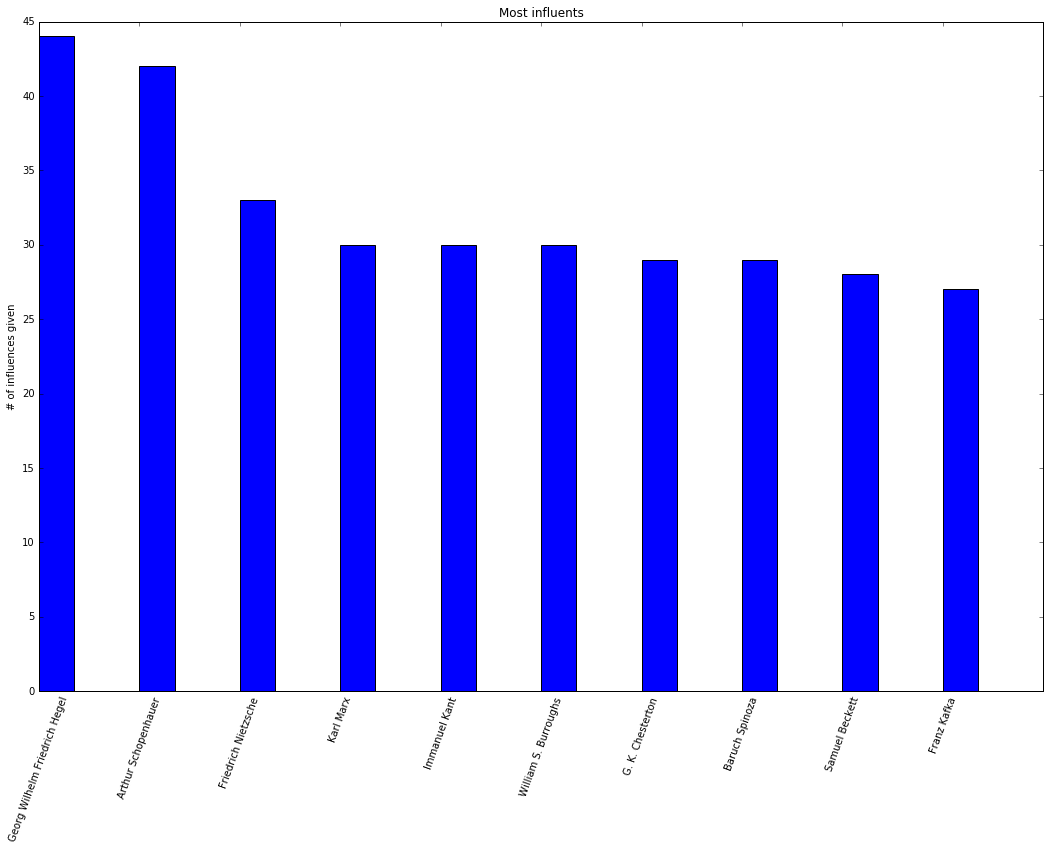

In [14]:
x = np.arange(len(most_influencers))
y = list(zip(*most_influencers))[1] # ?* http://stackoverflow.com/questions/5917522/unzipping-and-the-operator
labels = list(zip(*most_influencers))[0]
y2max = max(y) + 1

plt.figure(figsize=(18,12), dpi=100)
plt.bar(x, y, width=0.35)
plt.xticks(x, labels)
plt.ylim(0, y2max)
plt.xticks(rotation=70)
plt.ylabel('# of influences given')
plt.title('Most influents')

In [15]:
most_influencers[0:10]

[('Georg Wilhelm Friedrich Hegel', 44),
 ('Arthur Schopenhauer', 42),
 ('Friedrich Nietzsche', 33),
 ('Karl Marx', 30),
 ('Immanuel Kant', 30),
 ('William S. Burroughs', 30),
 ('G. K. Chesterton', 29),
 ('Baruch Spinoza', 29),
 ('Samuel Beckett', 28),
 ('Franz Kafka', 27)]

> * __What are the 10 personalities that were influenced by the most number of people?__

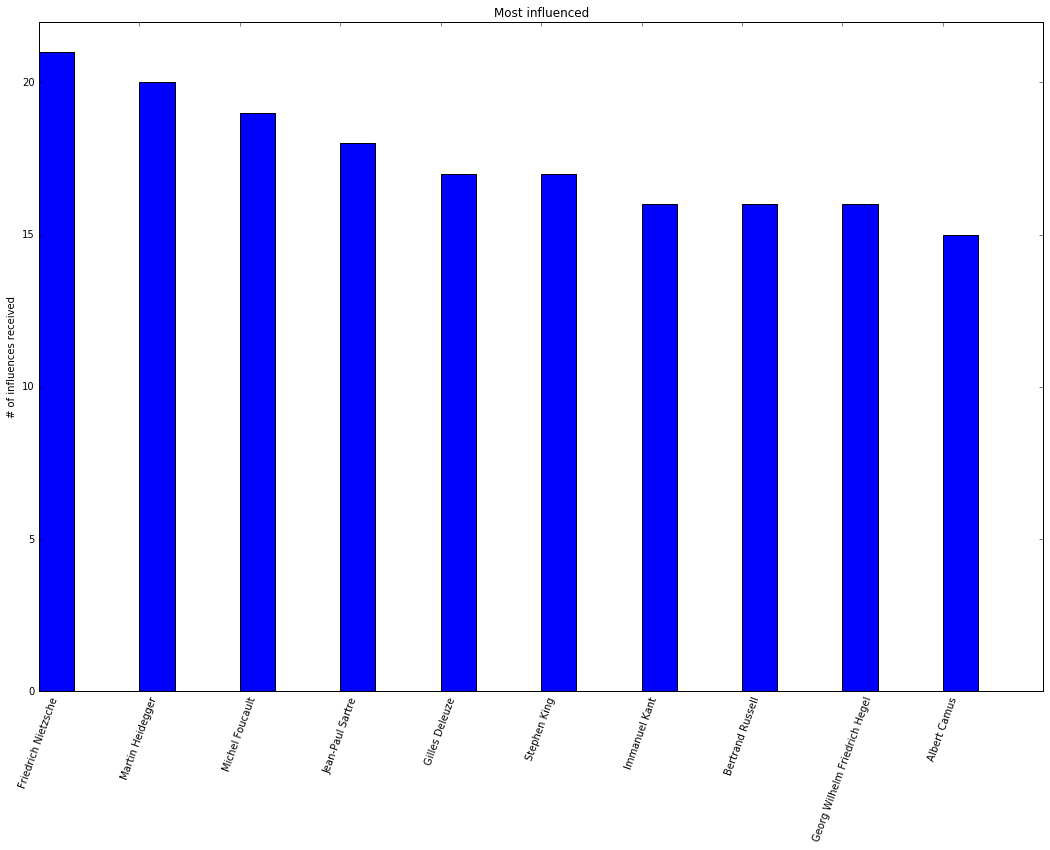

In [17]:
most_influenced = influenced_count.most_common(10)
x = np.arange(len(most_influenced))
y = list(zip(*most_influenced))[1]
labels = list(zip(*most_influenced))[0]
y2max = max(y) + 1

plt.figure(figsize=(18,12), dpi=100)
plt.bar(x, y, width=0.35)
plt.xticks(x, labels)
plt.ylim(0, y2max)
plt.xticks(rotation=70)
plt.ylabel('# of influences received')
plt.title('Most influenced')

In [18]:
most_influenced[0:10]

[('Friedrich Nietzsche', 21),
 ('Martin Heidegger', 20),
 ('Michel Foucault', 19),
 ('Jean-Paul Sartre', 18),
 ('Gilles Deleuze', 17),
 ('Stephen King', 17),
 ('Immanuel Kant', 16),
 ('Bertrand Russell', 16),
 ('Georg Wilhelm Friedrich Hegel', 16),
 ('Albert Camus', 15)]

____

__treating data for clustering__

In [37]:
list_influencers = influencers_count.most_common(1548)
list_influenced = influenced_count.most_common(2745)

In [38]:
# Pegando apenas os caras que influenciam mais que um, e os que são influenciados por mais que um

influencers_out = list(k for k,v in list_influencers if v == 1)
influenced_out = list(k for k,v in list_influenced if v == 1)
print(len(influencers_out), len(influenced_out))

influencers_in = list(k for k,v in list_influencers if v > 1)
influenced_in = list(k for k,v in list_influenced if v > 1)
#print(len(influencers_in), len(influenced_in))

723 1876


In [39]:
# Processamento dos dados pra gerar a matriz

inf_filtered = np.array([inf for inf in influences if inf[0] not in influencers_out], dtype=str)
print('Dimensions: {}'.format(inf_filtered.shape))
inf_filtered[:10]

Dimensions: (4286, 2)


array([['Ferdinand de Saussure', 'Jacques Lacan'],
       ['Georg Wilhelm Friedrich Hegel', 'Jacques Lacan'],
       ['Sigmund Freud', 'Jacques Lacan'],
       ['Benjamin Tucker', 'Robert Anton Wilson'],
       ["Brian O'Nolan", 'Robert Anton Wilson'],
       ['Terence McKenna', 'Robert Anton Wilson'],
       ['Colin Wilson', 'Robert Anton Wilson'],
       ['Robert W. Chambers', 'Robert Anton Wilson'],
       ['Aristotle', 'Alexander the Great'],
       ['Charles Grafton Page', 'Alexander Graham Bell']], 
      dtype='<U208')

In [40]:
# Esse é o array que vamos usar pro grafo e matriz de adjacência

inf_filtered_final = np.array([inf for inf in inf_filtered if inf[1] not in influenced_out], dtype=str)
print('Dimensions: {}'.format(inf_filtered_final.shape))
inf_filtered_final[:10]

Dimensions: (2805, 2)


array([['Ferdinand de Saussure', 'Jacques Lacan'],
       ['Georg Wilhelm Friedrich Hegel', 'Jacques Lacan'],
       ['Sigmund Freud', 'Jacques Lacan'],
       ['Benjamin Tucker', 'Robert Anton Wilson'],
       ["Brian O'Nolan", 'Robert Anton Wilson'],
       ['Terence McKenna', 'Robert Anton Wilson'],
       ['Colin Wilson', 'Robert Anton Wilson'],
       ['Robert W. Chambers', 'Robert Anton Wilson'],
       ['Emily Brontë', 'Anne Brontë'],
       ['Lord Byron', 'Anne Brontë']], 
      dtype='<U832')

In [41]:
# Criando uma lista com a ordem pra organizar a matriz de adjacências
c1 = Counter(inf_filtered_final[:,0])
c2 = Counter(inf_filtered_final[:,1])

ordem1 = c1.most_common(len(c1))
ordem2 = c2.most_common(len(c2))

ordem = []
for i in range(0,len(ordem1)):
    ordem.append(ordem1[i][0])
for j in range(0,len(ordem2)):
    if ordem2[j][0] not in ordem:
        ordem.append(ordem2[j][0])

print('nº de linhas (influenciadores):', len(ordem1), 'nº de colunas:', len(ordem))

nº de linhas (influenciadores): 721 nº de colunas: 1269


In [42]:
G=nx.DiGraph()
G.add_nodes_from(inf_filtered_final[0:,0])
G.add_nodes_from(inf_filtered_final[0:,1])

for i in range(1,len(inf_filtered_final)):

    G.add_edge(inf_filtered_final[i,0],inf_filtered_final[i,1])

In [ ]:
A = nx.adjacency_matrix(G, nodelist=ordem)
A

* __What are the 5 major "clusters" of personalities who were influenced by a similar group of the same influencers?__

#### Grupos de dois influenciadores:

In [72]:
m = len(ordem1)

lista_2 = []

for i in range(0, m):
    
    soma=0
    
    for j in range(i+1, m):
        
        lista_2.append([ordem[i]] + [ordem[j]])
        
lista_2[0:10]

[['Georg Wilhelm Friedrich Hegel', 'Friedrich Nietzsche'],
 ['Georg Wilhelm Friedrich Hegel', 'Arthur Schopenhauer'],
 ['Georg Wilhelm Friedrich Hegel', 'Immanuel Kant'],
 ['Georg Wilhelm Friedrich Hegel', 'Baruch Spinoza'],
 ['Georg Wilhelm Friedrich Hegel', 'Franz Kafka'],
 ['Georg Wilhelm Friedrich Hegel', 'Søren Kierkegaard'],
 ['Georg Wilhelm Friedrich Hegel', 'Johann Wolfgang von Goethe'],
 ['Georg Wilhelm Friedrich Hegel', 'Samuel Beckett'],
 ['Georg Wilhelm Friedrich Hegel', 'Jorge Luis Borges'],
 ['Georg Wilhelm Friedrich Hegel', 'Karl Marx']]

In [74]:
lista_2[0]

['Georg Wilhelm Friedrich Hegel', 'Friedrich Nietzsche']

In [55]:
n = len(ordem)


clusters_2 = np.zeros((len(lista_1),2), dtype=int)

count = 0

for k in range(0, m):
        
    soma = 0
    
    for j in range(k+1, m):
            
            x = A[k]+A[j]
            soma = (x==2).sum()        
                    
            clusters_2[count,0] = count        
            clusters_2[count,1] = soma  
            
            count += 1
clusters_2

array([[     0,     12],
       [     1,      4],
       [     2,     10],
       ..., 
       [259557,      0],
       [259558,      0],
       [259559,      0]])

In [56]:
# Agora vamos pegar as 5 duplas que têm maior número de seguidores
x = sorted(clusters_2, key=lambda tup:tup[1], reverse=True)[0:5]
x

[array([ 0, 12]),
 array([ 2, 10]),
 array([13,  8]),
 array([724,   8]),
 array([1443,    8])]

In [58]:
grupos_2 = []
for i in x:
    grupos_2.append(i[0])
grupos_2

[0, 2, 13, 724, 1443]

In [85]:
philodict = {}
a = np.copy(inf_filtered_final)

for i in ordem:
    ind, position = np.where(a == i)
    val = list(a[j][1] for j in ind if position[np.where(ind == j)] == 0)
    philodict.update({i: val})

In [84]:
for i in grupos_2:
    inf = []
    influencers = lista_2[i]
    influenced = set(philodict[lista_2[i][0]]) & set(philodict[lista_2[i][1]])
    print('Influencers:', influencers, 'Influenced:', influenced)

Influencers: ['Georg Wilhelm Friedrich Hegel', 'Friedrich Nietzsche'] Influenced: {'Leo Strauss', 'Judith Butler', 'Jean-Paul Sartre', 'Jacques Derrida', 'Karl Jaspers', 'Georges Bataille', 'Albert Camus', 'Herbert Marcuse', 'Martin Heidegger', 'Gilles Deleuze', 'Theodor W. Adorno', 'Alexandre Kojève'}
Influencers: ['Georg Wilhelm Friedrich Hegel', 'Immanuel Kant'] Influenced: {'Friedrich Nietzsche', 'Leo Strauss', 'Ralph Waldo Emerson', 'Søren Kierkegaard', 'Jean-Paul Sartre', 'Karl Jaspers', 'Giovanni Gentile', 'Jürgen Habermas', 'Martin Heidegger', 'Gilles Deleuze'}
Influencers: ['Georg Wilhelm Friedrich Hegel', 'Jean-Jacques Rousseau'] Influenced: {'Friedrich Nietzsche', 'Karl Marx', 'Leo Strauss', 'Claude Lévi-Strauss', 'Jacques Derrida', 'Mikhail Bakunin', 'Friedrich Engels', 'Benedetto Croce'}
Influencers: ['Friedrich Nietzsche', 'Søren Kierkegaard'] Influenced: {'Franz Kafka', 'Jean-Paul Sartre', 'Jacques Derrida', 'Martin Buber', 'Karl Jaspers', 'Albert Camus', 'Martin Heidegg

#### Grupos de 3 influenciadores: 

O loop nunca acabou, precisamos de uma ideia melhor... :(

In [90]:
# Agora vamos pegar as 5 duplas que têm maior número de seguidores
x = sorted(clusters_2, key=lambda tup:tup[1], reverse=True)[0:200]
x

grupos_3 = []
for i in x:
    grupos_3.append(i[0])

In [ ]:
m = len(ordem1)

lista_3 = []

for i in range(0, m):
    
    for j in range(i+1, m):
        
        for k in range(j+1, m):
        
            lista_3.append([ordem[i] +' | '+ ordem[j] + '|' + ordem[k]])
        
lista_3[0:10]

In [ ]:
n = len(ordem)

clusters_3 = np.zeros((len_lista_3,2), dtype=int)

count = 0

for k in range(0, m):
        
    soma = 0
    
    for j in range(k+1, m):
        
        for l in range(j+1, m):
            
            x = A[k]+A[j]+A[l]
            soma = (x==3).sum()        
                    
            clusters_3[count,0] = count        
            clusters_3[count,1] = soma  
            
            count += 1

____

__getting birthplace data__

getting list of unique philosophers in the dataset:

In [20]:
philosophers = list(influences[1:,0]) + list(influences[1:,1])
uqphilo = list(set(philosophers)) #valores únicos
print(len(uqphilo))

3589


In [21]:
uqphilo[0:10]

['Dennis Cooper',
 'Wolfgang Pauli',
 'Amvrosii Metlynsky',
 'Han Ryner',
 'André Malraux',
 'Giorgos Seferis',
 'Dominik Smole',
 'Frederic Bartlett',
 'Jimmy Wales',
 'Haha (entertainer)']

creating list of the philosopher's URLs at DBpedia, so that we can query them:

In [22]:
#creating list of urls
urls = np.copy(uqphilo)

for i in range(len(uqphilo)):
    urls[i] = urls[i].replace(' ', '_')
    url_prefix = 'http://dbpedia.org/resource/'
    urls[i] = url_prefix + urls[i]

In [23]:
urls[0:10]

array(['http://dbpedia.org/resource/Dennis_Cooper',
       'http://dbpedia.org/resource/Wolfgang_Pauli',
       'http://dbpedia.org/resource/Amvrosii_Metlynsky',
       'http://dbpedia.org/resource/Han_Ryner',
       'http://dbpedia.org/resource/André_Malraux',
       'http://dbpedia.org/resource/Giorgos_Seferis',
       'http://dbpedia.org/resource/Dominik_Smole',
       'http://dbpedia.org/resource/Frederic_Bartlett',
       'http://dbpedia.org/resource/Jimmy_Wales',
       'http://dbpedia.org/resource/Haha_(entertainer)'], 
      dtype='<U52')

creating empty dataframe with the features to be queried for:

In [24]:
nationalities = pd.DataFrame(index = arange(5000), columns = ['philosopher', 'birthplace', 'nationality', 'ethnicity', 'description'])
nationalities.head(2)

,philosopher,birthplace,nationality,ethnicity,description
0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN


defining the function which will do the actual querying using SPARQL:

In [25]:
def query_dbpedia(alist, n):
    i = 0
    for j in range(0, len(alist), n): #gotta chunk the urls, because we can't query for all of them at the same time (server limit)
        chunk = alist[j:j + n]
        philo_str = ''
        
        for u in chunk:
            philo_str += '<' + u + '> ' #structuring URL
        
        sparql = SPARQLWrapper("http://dbpedia.org/sparql")
        sparql.setQuery('''
        SELECT * { 
          VALUES ?person { %s }
        OPTIONAL {?person <http://dbpedia.org/ontology/birthPlace> ?place} .
        OPTIONAL {?person <http://dbpedia.org/ontology/nationality> ?nation} .
        OPTIONAL {?person <http://dbpedia.org/ontology/ethnicity> ?ethn} .
        OPTIONAL {?person <http://dbpedia.org/ontology/description> ?desc} .
        }
        ''' % (philo_str))  # substituting for the chunk
        sparql.setReturnFormat(JSON)
        results = sparql.query().convert()

        # building the dataframe
        for result in results["results"]["bindings"]:
            nationalities.loc[i, 'philosopher'] = (result["person"]["value"])
            try: #gotta check if empty, therefore the try, except
                nationalities.loc[i, 'nationality'] = (result["nation"]["value"])
            except KeyError:
                pass
            try:
                nationalities.loc[i, 'ethnicity'] = (result["ethn"]["value"])
            except KeyError:
                pass
            try:
                nationalities.loc[i, 'birthplace'] = (result["place"]["value"])
            except KeyError:
                pass
            try:
                nationalities.loc[i, 'description'] = (result["desc"]["value"])
            except KeyError:
                pass
            i += 1
    return nationalities

calling the function with a chunk of size 125 (a little more will reach the query limit):

In [26]:
nationalities = query_dbpedia(urls, 125)
nationalities.head()

,philosopher,birthplace,nationality,ethnicity,description
0,http://dbpedia.org/resource/Kazi_Nazrul_Islam,http://dbpedia.org/resource/Churulia,http://dbpedia.org/resource/Bangladeshis,http://dbpedia.org/resource/Bengalis,NaN
1,http://dbpedia.org/resource/Kazi_Nazrul_Islam,http://dbpedia.org/resource/India,http://dbpedia.org/resource/Bangladeshis,http://dbpedia.org/resource/Bengalis,NaN
2,http://dbpedia.org/resource/Kazi_Nazrul_Islam,http://dbpedia.org/resource/West_Bengal,http://dbpedia.org/resource/Bangladeshis,http://dbpedia.org/resource/Bengalis,NaN
3,http://dbpedia.org/resource/Kazi_Nazrul_Islam,http://dbpedia.org/resource/Bengal_Presidency,http://dbpedia.org/resource/Bangladeshis,http://dbpedia.org/resource/Bengalis,NaN
4,http://dbpedia.org/resource/Kazi_Nazrul_Islam,http://dbpedia.org/resource/Bardhaman_district,http://dbpedia.org/resource/Bangladeshis,http://dbpedia.org/resource/Bengalis,NaN


In [27]:
backup = nationalities.copy()

gotta wipe the duplicates:

obs: we are keeping the last duplicate because it's usually the one where birthplace yields the country, not the city of birth.  this is not true for all philosophers.

In [28]:
nationalities = backup.copy()
nationalities.drop_duplicates(subset = 'philosopher', inplace = True, keep = 'last')
nationalities.reset_index(inplace = True)
nationalities.drop('index', axis =1, inplace = True)
nationalities.head()

,philosopher,birthplace,nationality,ethnicity,description
0,http://dbpedia.org/resource/Kazi_Nazrul_Islam,http://dbpedia.org/resource/Presidencies_and_p...,http://dbpedia.org/resource/Bangladeshis,http://dbpedia.org/resource/Bengalis,NaN
1,http://dbpedia.org/resource/Amvrosii_Metlynsky,http://dbpedia.org/resource/Poltava_Oblast,http://dbpedia.org/resource/Ukraine,http://dbpedia.org/resource/Ukrainians,NaN
2,http://dbpedia.org/resource/Albert_Hofmann,"http://dbpedia.org/resource/Baden,_Switzerland",http://dbpedia.org/resource/Switzerland,NaN,NaN
3,http://dbpedia.org/resource/Helen_Frankenthaler,http://dbpedia.org/resource/New_York_City,http://dbpedia.org/resource/United_States,NaN,NaN
4,http://dbpedia.org/resource/Robert_Lowell,http://dbpedia.org/resource/United_States,http://dbpedia.org/resource/United_States,NaN,NaN


In [29]:
nationalities.shape[0]

3589

cleaning the results:

In [30]:
def parse_dbpedia(df):
    df.fillna('nan', inplace = True)
    for c in df.columns.values:
        df[c] = df[c].str.replace(pat = 'http://dbpedia.org/resource/', repl = '')
        df[c] = df[c].str.replace(pat = '_', repl = ' ')
    return df

In [31]:
parse_dbpedia(nationalities)
nationalities.head(7)

,philosopher,birthplace,nationality,ethnicity,description
0,Kazi Nazrul Islam,Presidencies and provinces of British India,Bangladeshis,Bengalis,nan
1,Amvrosii Metlynsky,Poltava Oblast,Ukraine,Ukrainians,nan
2,Albert Hofmann,"Baden, Switzerland",Switzerland,nan,nan
3,Helen Frankenthaler,New York City,United States,nan,nan
4,Robert Lowell,United States,United States,nan,nan
5,Larry Bell (artist),Chicago,United States,nan,nan
6,Ei-ichi Negishi,Manchuria,Japan,nan,nan


by eyeballing the data we found that the nationality features had different accuracies, so we choose which available feature better answers the nationality question:

In [32]:
nationalities['ans'] = 'nan'
for i in nationalities.index.values:
    if nationalities.loc[i, 'nationality'] != 'nan':
        nationalities.loc[i, 'ans'] = nationalities.loc[i, 'nationality']
    elif nationalities.loc[i, 'birthplace'] != 'nan':
        nationalities.loc[i, 'ans'] = nationalities.loc[i, 'birthplace']
    elif nationalities.loc[i, 'ethnicity'] != 'nan':
        nationalities.loc[i, 'ans'] = nationalities.loc[i, 'ethnicity']
    else:
        nationalities.loc[i, 'ans'] = nationalities.loc[i, 'description']
        
nationalities.head(10)

,philosopher,birthplace,nationality,ethnicity,description,ans
0,Kazi Nazrul Islam,Presidencies and provinces of British India,Bangladeshis,Bengalis,nan,Bangladeshis
1,Amvrosii Metlynsky,Poltava Oblast,Ukraine,Ukrainians,nan,Ukraine
2,Albert Hofmann,"Baden, Switzerland",Switzerland,nan,nan,Switzerland
3,Helen Frankenthaler,New York City,United States,nan,nan,United States
4,Robert Lowell,United States,United States,nan,nan,United States
5,Larry Bell (artist),Chicago,United States,nan,nan,United States
6,Ei-ichi Negishi,Manchuria,Japan,nan,nan,Japan
7,Johannes Letzmann,Russians,Germans,nan,nan,Germans
8,Giorgos Seferis,"Urla, İzmir",Greece,nan,nan,Greece
9,David Gemmell,London,England,nan,nan,England


In [33]:
nationalities.tail(20)

# for some reason the last few queries yielded no results, although some were available at DBpedia.

,philosopher,birthplace,nationality,ethnicity,description,ans
3569,Garrett Birkhoff,"Princeton, New Jersey",nan,nan,nan,"Princeton, New Jersey"
3570,Jerry Fodor,New York City,nan,nan,nan,New York City
3571,Ernst Jünger,German Empire,nan,nan,nan,German Empire
3572,Henry Ward Beecher,"Litchfield, Connecticut",nan,nan,nan,"Litchfield, Connecticut"
3573,William Styron,"Newport News, Virginia",nan,nan,nan,"Newport News, Virginia"
3574,Michel Foucault,France,nan,nan,nan,France
3575,Howard Stern,New York City,nan,nan,nan,New York City
3576,Ulf Grenander,Sweden,nan,nan,nan,Sweden
3577,Tatsuo Hori,nan,nan,nan,nan,nan
3578,Sextus Empiricus,nan,nan,nan,nan,nan


> * __What are the countries that generated the greatest influential?__

In [34]:
nation_count = Counter(nationalities.loc[:,'ans'])

In [35]:
len(uqphilo)

3589

In [36]:
nation_count.most_common(20)

[('nan', 474),
 ('United States', 283),
 ('New York City', 65),
 ('France', 61),
 ('Americans', 53),
 ('Germany', 45),
 ('United Kingdom', 42),
 ('German Empire', 35),
 ('Austria-Hungary', 31),
 ('Canada', 31),
 ('Romania', 31),
 ('Brooklyn', 30),
 ('Netherlands', 29),
 ('Chicago', 28),
 ('Italy', 28),
 ('London', 26),
 ('India', 24),
 ('England', 23),
 ('Japan', 21),
 ('Poland', 20)]

notes:

* out of 3589 unique philosophers, our DBpedia query could not find the nationality of 474 (13%) of them;
* more data cleaning is needed, as is patently obvious by the fact that the United States leads philosophy production followed by the "country" of New York City.  this is a problem with wikipedia/DBpedia not structuring well the birthplace data.

____

#### grafo de influências

generating a directed graph using Networkx:

In [7]:
G = nx.DiGraph()
G.add_nodes_from(influences[1:,0])
G.add_nodes_from(influences[1:,1])

for i in range(1,len(influences)):
    
    G.add_edge(influences[i,0],influences[i,1])

In [8]:
print('Number of nodes is: {}'.format(G.number_of_nodes()))
print('Number of edges is: {}'.format(G.number_of_edges()))

Number of nodes is: 3589
Number of edges is: 5008



__histogram of nodes' degrees__

[0, 2078, 545, 262, 157, 121, 82, 69, 51, 40, 35, 25, 24, 14, 10]


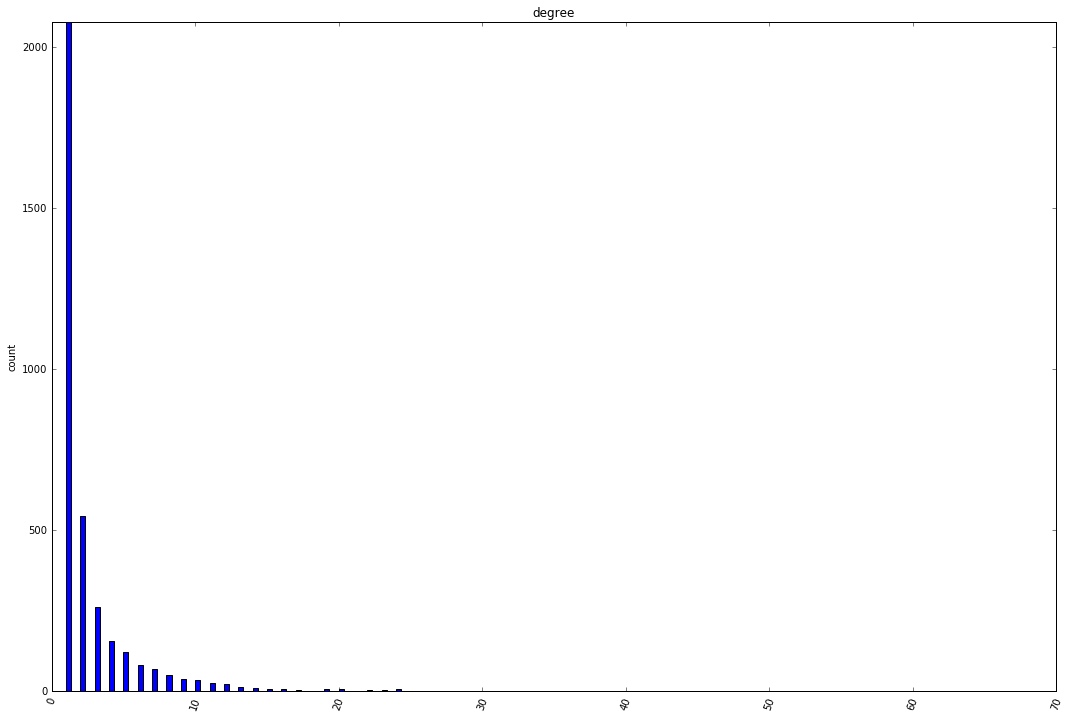

In [15]:
y = nx.degree_histogram(G)
x = np.arange(len(y))
y2max = max(y) + 1

plt.figure(figsize=(18,12), dpi=100)
plt.bar(x, y, width=0.35)
plt.ylim(0, y2max)
plt.xticks(rotation=70)
plt.ylabel('count')
plt.title('degree')

print(y[0:15])

In [16]:
# graph density
nx.density(G)

0.0003889004337233831

#### longest chains of influence

to employ an algorithm that calculates the longest paths (influence chains), we need to get rid of cycles in our graph.  our approach randomly removes edges of two-node cycles, producing different graphs which are then fed to the algorithm which finds the longest path in each of them.  because each graph is different, we create n > 5 graphs, which yield n longest paths, and we then select the 5 biggest paths out of the n longest paths.

In [14]:
def rand_uncycle(graph, n_path):
    
    results = np.empty([n_path], dtype = 'object, int') # retrieve using results[j][0 or 1]
    i = 0
    s = [rd.randrange(2) for _ in range(n_path * 1000)] # random 0s and 1s
    k = 0
    
    while k < n_path:
        
        G1 = graph.to_directed()      
        l = 0
        
        while not nx.is_directed_acyclic_graph(G1):
            if l < 4: # limiting loops, because if there are no two-node cycles it won't finish.
                cycles = nx.simple_cycles(G1)
                for c in cycles:
                    if len(c) == 2:
                        G1.remove_edge(c[s[i]], c[not s[i]])
                        i += 1
                    l += 1
            else:
                break
                print('oops!')

        else:
            results[k][0] = nx.dag_longest_path(G1)
            results[k][1] = nx.dag_longest_path_length(G1)
            k += 1
            
    
    return results            

finding 25 'longest' paths:

In [24]:
res = rand_uncycle(G, 25)

In [25]:
backup = np.copy(res)

In [65]:
#res = np.copy(backup) # to use in case cell below is run more than one time.

> * __What are the 5 major influences chains (eg, A -> B -> C -> ...)?__

In [66]:
sort_res = sorted(res, key=lambda tup: tup[1], reverse = True) # sorting by size
for i in range(len(sort_res)):
    sort_res[i][0] = ' , '.join(sort_res[i][0]) #joining list into string, because a hashable object is needed.
paths = {}
i = 0

for path, size in sort_res:
    if (path not in paths) and (i<5): # we see this key for the first time
        paths[path] = (path, size)
        i += 1 # because it is sorted we don't need to do it more than 5 times.
        
    
result = paths

provided in no particular order.

In [67]:
result

{'Thales , Anaximander , Pythagoras , Parmenides , Zeno of Elea , Protagoras , Plato , Aristotle , Averroes , Maimonides , Thomas Aquinas , Meister Eckhart , Nicholas of Cusa , Giordano Bruno , Baruch Spinoza , Gottfried Leibniz , Christian Wolff (philosopher) , Alexander Gottlieb Baumgarten , Immanuel Kant , Friedrich Wilhelm Joseph Schelling , Georg Wilhelm Friedrich Hegel , Max Stirner , Friedrich Nietzsche , George Santayana , William James , Émile Durkheim , Henri Bergson , Alfred North Whitehead , Bertrand Russell , Rudolf Carnap , Nelson Goodman , Willard Van Orman Quine , Hilary Putnam , Donald Davidson (philosopher) , Richard Rorty , Robert Brandom': ('Thales , Anaximander , Pythagoras , Parmenides , Zeno of Elea , Protagoras , Plato , Aristotle , Averroes , Maimonides , Thomas Aquinas , Meister Eckhart , Nicholas of Cusa , Giordano Bruno , Baruch Spinoza , Gottfried Leibniz , Christian Wolff (philosopher) , Alexander Gottlieb Baumgarten , Immanuel Kant , Friedrich Wilhelm Jos

____

> * __What are the areas of greatest influence?__

if we interpret areas as being domains of knowledge, the answer is straightforward: philosophy is the most influential area of occupation, followed by writing, as can be seen by the list of most influential people:

In [76]:
most_influencers[0:15]

[('Georg Wilhelm Friedrich Hegel', 44),
 ('Arthur Schopenhauer', 42),
 ('Friedrich Nietzsche', 33),
 ('Karl Marx', 30),
 ('Immanuel Kant', 30),
 ('William S. Burroughs', 30),
 ('Baruch Spinoza', 29),
 ('G. K. Chesterton', 29),
 ('Samuel Beckett', 28),
 ('Franz Kafka', 27),
 ('David Hume', 26),
 ('Jorge Luis Borges', 25),
 ('Johann Wolfgang von Goethe', 25),
 ('Søren Kierkegaard', 25),
 ('Jean-Jacques Rousseau', 24)]

in the above list, William S. Burroughs, G. K. Chesterton, Samuel Beckett, Franz Kafka, Jorge Luis Borges, and Johann Wolfgang von Goethe are writers, and all the rest are philosophers.

____

* __Creating a graphical representation of the graph:__
Exporting to Gephi
https://gephi.org/users/supported-graph-formats/  